In [1]:
# ==================================
# Experiment 2
# ==================================

# demonstration to find the maximal l_p ball at a point x_0, within which,
# the class label of a random classifier is equal to C(x_0).
# network is trained to classify random points in R^2. The effects of l_1
# regularization in training are demonstrated.

In [2]:
# =====================
# Imports
# =====================

from geocert import compute_boundary_batch, batch_GeoCert, incremental_GeoCert
from plnn import PLNN
from _polytope_ import Polytope, from_polytope_dict
import utilities as utils
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
# from convex_adversarial import robust_loss

ModuleNotFoundError: No module named 'geocert'

In [3]:
# apply incremental geocert to a normal and l1-regularized classifier. Finds maximal l_p balls
# for random points in R^2.

# ==================================
# Generate Training Points
# ==================================

print('===============Generating Training Points============')
# random points at least 2r apart
m = 12
np.random.seed(3)
x = [np.random.uniform(size=(2))]
r = 0.1
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)

epsilon = r/2

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()

print('===============Points Generated============')

===============Generating Training Points============
===============Points Generated============


===============Initializing Network============
Sequential(
  (1): Linear(in_features=2, out_features=8, bias=True)
  (2): ReLU()
  (3): Linear(in_features=8, out_features=2, bias=True)
  (4): ReLU()
  (5): Linear(in_features=2, out_features=2, bias=True)
)
===============Training Network============
error: tensor(0.5833)
error: tensor(0.5833)
error: tensor(0.4167)
error: tensor(0.4167)
error: tensor(0.4167)
error: tensor(0.3333)
error: tensor(0.2500)
error: tensor(0.2500)
error: tensor(0.2500)
error: tensor(0.2500)


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


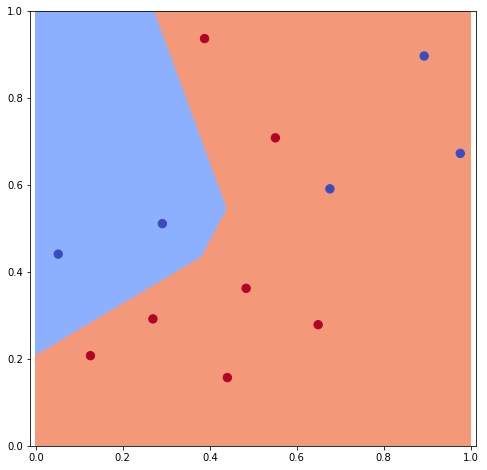

===============Collecting Polytopes============
number of polytopes: 12
===============Finding Classification Boundary Facets============
an unbounded polytope was plotted imperfectly


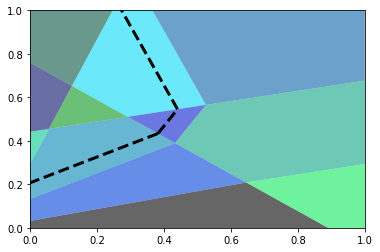

===============Finding Projection============
lp_norm:  l_2
tensor([[0.5508],
        [0.7081]])
from point: 
tensor([[0.5508],
        [0.7081]])
/Users/jordanm/grad/geometric-certificates
---Initial Polytope---
num facets:  4
---Opening New Polytope---
num facets:  3
an unbounded polytope was plotted imperfectly
an unbounded facet was plotted imperfectly
an unbounded facet was plotted imperfectly
an unbounded facet was plotted imperfectly


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jordanm/grad/geometric-certificates/plots/incremental_geocert/0.png'

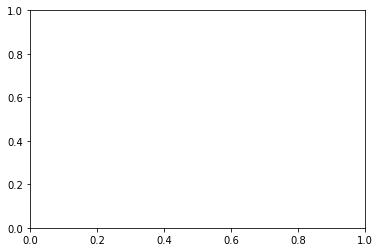

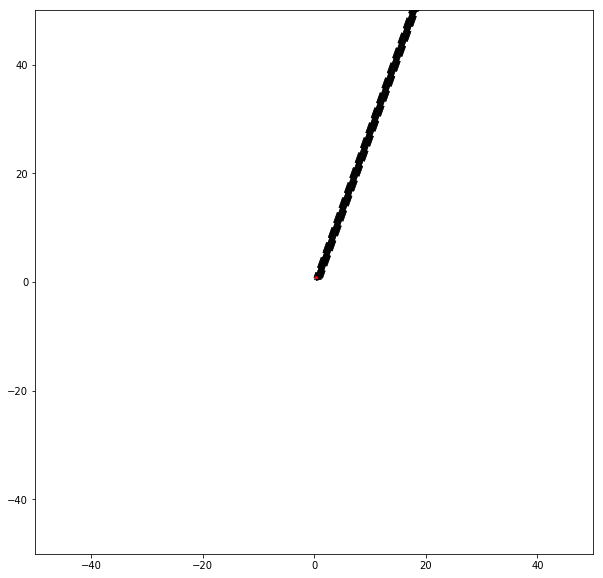

In [4]:
# ==================================
# Initialize Network
# ==================================

print('===============Initializing Network============')
layer_sizes = [2, 8, 2, 2]
network = PLNN(layer_sizes)
net = network.net


# ==================================
# Train Network
# ==================================

print('===============Training Network============')
opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(1000):
    out = net(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(y))
    err = (out.max(1)[1].data != y).float().mean()
    if i % 100 == 0:
        print('error:', err)
    opt.zero_grad()
    (l).backward()
    opt.step()

# ==================================
# Visualize:  classifier boundary
# ==================================

XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = network(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100, 100).data.numpy()

_, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0, 1, 0, 1])

plt.show()

# ==================================
# Visualize: baseline classifier ReLu regions
# ==================================

print('===============Collecting Polytopes============')
num_pts = 200
xylim = 1.0

unique_relu_configs_list, unique_bin_acts, _, _ = utils.get_unique_relu_configs(network, xylim, num_pts)
print('number of polytopes:', len(unique_bin_acts))
color_dict = utils.get_color_dictionary(unique_bin_acts)
polytope_list = []


for relu_configs, unique_act in zip(unique_relu_configs_list, unique_bin_acts):
    polytope_dict = network.compute_polytope_config(relu_configs, True)
    polytope = from_polytope_dict(polytope_dict)
    polytope_list.append(polytope)
    # colors.append(color_dict[unique_act])
colors = utils.get_spaced_colors(200)[0:len(polytope_list)]
x_0 = torch.Tensor([[0.3], [0.5]])

print('===============Finding Classification Boundary Facets============')

true_label = int(network(x_0).max(1)[1].item())  # what the classifier outputs

adversarial_facets = []
for polytope in polytope_list:
    polytope_adv_constraints = network.make_adversarial_constraints(polytope.config,
                                                                    true_label)

    for facet in polytope_adv_constraints:
        adversarial_facets.append(facet)


# ------------------------------
# Plot Polytopes, boundary, and lp norm
# ------------------------------

ax = plt.gca()
alpha = 0.6
xylim = 1.0

utils.plot_polytopes_2d(polytope_list, colors, alpha, xylim, ax)
utils.plot_facets_2d(adversarial_facets, xylim=xylim, ax=ax, color='black', linestyle='dashed')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.show()


# ==================================
# Find Projections
# ==================================

lp_norm = 'l_2'
ts = []
pts = x

for pt in pts:
    print('===============Finding Projection============')
    print('lp_norm: ', lp_norm)
    x_0 = torch.Tensor(pt.reshape([2, 1]))
    print(x_0)
    print('from point: ')
    print(x_0)

    ax = plt.axes()
    cwd = os.getcwd()
    print(cwd)
    plot_dir = cwd + '/plots/incremental_geocert/'

    t = incremental_GeoCert(lp_norm, network, x_0, ax, plot_dir)

    print('the final projection value:', t)
    ts.append(t)

# ==================================
# Visualize: incremental geocert projections
# ==================================

XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = network(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

_, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0, 1, 0, 1])

for pt, t, y in zip(pts, ts, y.numpy()):
    if lp_norm == 'l_2':
        utils.plot_l2_norm(pt, t, ax=ax)
    elif lp_norm == 'l_inf':
        utils.plot_linf_norm(pt, t, ax=ax)
    else:
        raise NotImplementedError

print('average_linf:', np.average(ts))

plt.show()

In [ ]:
# apply incremental geocert to a normal and l1-regularized classifier. Finds maximal l_p balls
# for random points in R^2.

# ==================================
# Generate Training Points
# ==================================

print('===============Generating Training Points============')
# random points at least 2r apart
m = 12
np.random.seed(3)
x = [np.random.uniform(size=(2))]
r = 0.16
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
# r = 0.145
epsilon = r/2

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()
print('===============Points Generated============')

In [ ]:
# ==================================
# Initialize Network
# ==================================

print('===============Initializing Network============')
network = PLNN(layer_sizes)
net = network.net


# ==================================
# Train Network
# ==================================

def l1_loss(net):

    return sum([_.norm(p=1) for _ in net.parameters() if _.dim() > 1])


print('===============Training Network with Regularization============')
opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(1000):
    out = net(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(y)).view([1])

    l1_scale = torch.Tensor([1e-4])
    l += l1_scale * l1_loss(net).view([1])

    err = (out.max(1)[1].data != y).float().mean()
    opt.zero_grad()
    (l).backward()
    opt.step()

print('error: ', err)



# ==================================
# Visualize:  regularized classifier boundary
# ==================================

XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = network(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100, 100).data.numpy()

_, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0, 1, 0, 1])

plt.show()

# ==================================
# Visualize: regularized classifier ReLu regions
# ==================================

print('===============Collecting Polytopes============')
num_pts = 200
xylim = 1.0

unique_relu_configs_list, unique_bin_acts, _, _ = utils.get_unique_relu_configs(network, xylim, num_pts)
print('number of polytopes:', len(unique_bin_acts))
color_dict = utils.get_color_dictionary(unique_bin_acts)
polytope_list = []


for relu_configs, unique_act in zip(unique_relu_configs_list, unique_bin_acts):
    polytope_dict = network.compute_polytope_config(relu_configs, True)
    polytope = from_polytope_dict(polytope_dict)
    polytope_list.append(polytope)
    # colors.append(color_dict[unique_act])
colors = utils.get_spaced_colors(200)[0:len(polytope_list)]
x_0 = torch.Tensor([[0.3], [0.5]])

print('===============Finding Classification Boundary Facets============')

true_label = int(network(x_0).max(1)[1].item())  # what the classifier outputs

adversarial_facets = []
for polytope in polytope_list:
    polytope_adv_constraints = network.make_adversarial_constraints(polytope.config,
                                                                    true_label)

    for facet in polytope_adv_constraints:
        adversarial_facets.append(facet)


# ------------------------------
# Plot Polytopes, boundary, and lp norm
# ------------------------------

ax = plt.gca()
alpha = 0.6
xylim = 1.0

utils.plot_polytopes_2d(polytope_list, colors, alpha, xylim, ax)
utils.plot_facets_2d(adversarial_facets, xylim=xylim, ax=ax, color='black', linestyle='dashed')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.show()


# ==================================
# Find Projections
# ==================================

lp_norm = 'l_2'
ts = []
pts = x

for pt in pts:
    print('===============Finding Projection============')
    print('lp_norm: ', lp_norm)
    x_0 = torch.Tensor(pt.reshape([2, 1]))
    print(x_0)
    print('from point: ')
    print(x_0)

    ax = plt.axes()
    cwd = os.getcwd()
    print(cwd)
    plot_dir = cwd + '/plots/incremental_geocert/'

    t = incremental_GeoCert(lp_norm, network, x_0, ax, plot_dir)

    print('the final projection value:', t)
    ts.append(t)

# ==================================
# Visualize: incremental geocert projections
# ==================================

XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = network(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

_, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0, 1, 0, 1])

for pt, t, y in zip(pts, ts, y.numpy()):
    if lp_norm == 'l_2':
        utils.plot_l2_norm(pt, t, ax=ax)
    elif lp_norm == 'l_inf':
        utils.plot_linf_norm(pt, t, ax=ax)
    else:
        raise NotImplementedError

print('average_linf:', np.average(ts))

plt.show()